In [1]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [16]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *(5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)
bnmean_running = torch.ones(1, n_hidden)
bnstd_running = torch.zeros(1, n_hidden)

parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [17]:
hpreact.shape

torch.Size([182580, 200])

In [18]:
nums = torch.tensor([np.arange(9)]).view(3, 3).float()
nums

/var/folders/70/z5v4k8l11vs05yb6dxp5c8m40000gn/T/ipykernel_34053/3665034663.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391829313/work/torch/csrc/utils/tensor_new.cpp:264.)
  nums = torch.tensor([np.arange(9)]).view(3, 3).float()


tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [19]:
nums.mean(0, keepdims=True)

tensor([[3., 4., 5.]])

In [20]:
hpreact.mean(0, keepdims=True).shape

torch.Size([1, 200])

In [21]:
hpreact.std(0, keepdims=True).shape

torch.Size([1, 200])

In [22]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  
  bnmeani = hpreact.mean(0, keepdims=True)
  bnstdi = hpreact.std(0, keepdims=True)
  hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias
  
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None

  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  


      0/ 200000: 3.2856
  10000/ 200000: 2.1340
  20000/ 200000: 2.1373
  30000/ 200000: 2.2285
  40000/ 200000: 2.0133
  50000/ 200000: 1.7307
  60000/ 200000: 2.2741
  70000/ 200000: 2.2340
  80000/ 200000: 2.3828
  90000/ 200000: 2.0722
 100000/ 200000: 2.2072
 110000/ 200000: 2.1703
 120000/ 200000: 2.2788
 130000/ 200000: 1.8803
 140000/ 200000: 1.7875
 150000/ 200000: 2.1805
 160000/ 200000: 1.9339
 170000/ 200000: 1.9587
 180000/ 200000: 2.1038
 190000/ 200000: 2.0363


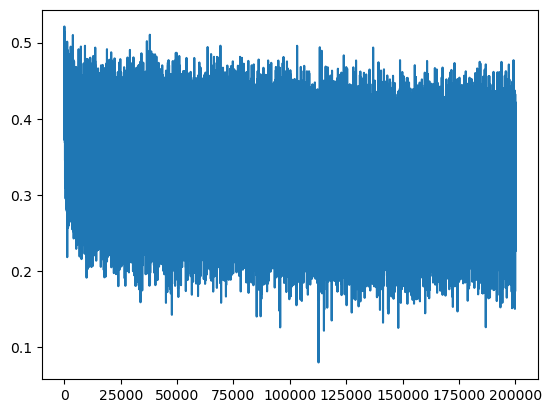

In [23]:
plt.plot(lossi)

In [12]:
# with torch.no_grad():
#   emb = C[Xtr]
#   embcat = emb.view(emb.shape[0], -1)
#   hpreact = embcat @ W1 + b1
#   bnmean = hpreact.mean(0, keepdims=True)
#   bnstd = hpreact.std(0, keepdims=True)

In [24]:
@torch.no_grad()
def split_loss(split):
  x, y = {'train': (Xtr, Ytr),
          'val': (Xdev, Ydev),
          'test': (Xte, Yte)
          }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 #+b1
  hpreact = bngain * (hpreact - bnmean)/bnstd + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  
split_loss('train')
split_loss('val')
  

train 2.1368637084960938
val 2.1810243129730225


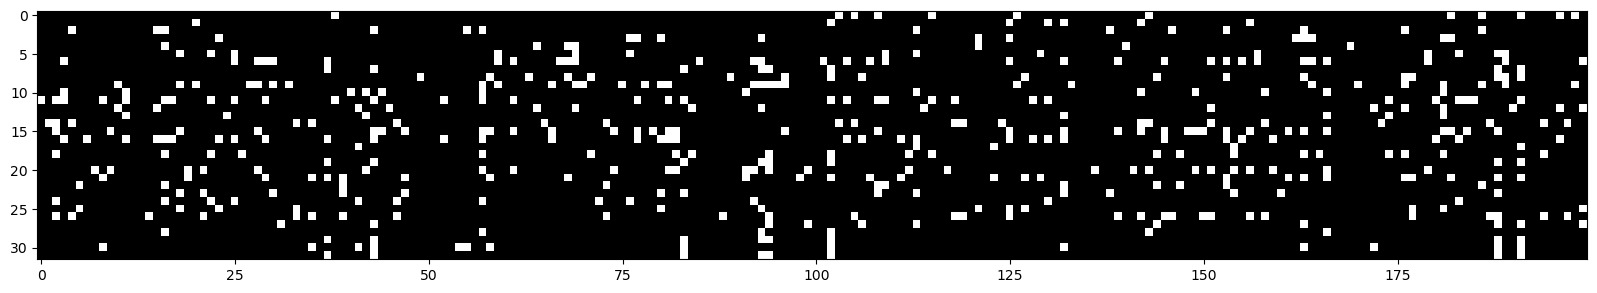

In [49]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

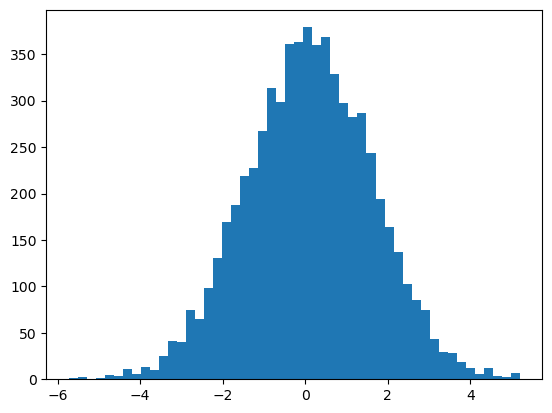

In [50]:
plt.hist(hpreact.view(-1).tolist(), 50);

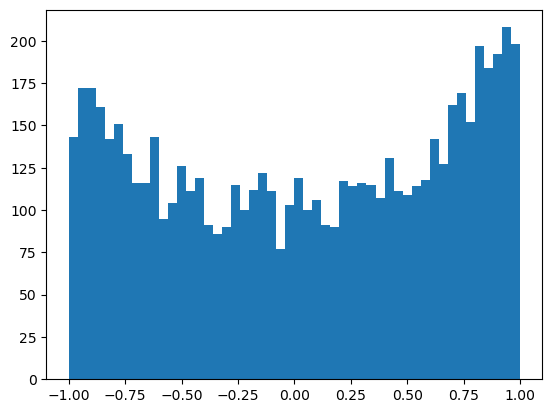

In [45]:
plt.hist(h.view(-1).tolist(), 50); # Why is this a problem? hint: derivative of tanh